# Alphalens Analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install alphalens #进行单因子分析的开源项目

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#进行单因子分析的开源项目'

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from pathlib import Path
import pandas as pd
from alphalens.tears import create_summary_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns

In [4]:
idx = pd.IndexSlice

## Load Data

In [5]:
with pd.HDFStore('data.h5') as store:
    lr_predictions = store['lr/predictions']
    lasso_predictions = store['lasso/predictions']
    lasso_scores = store['lasso/scores']
    ridge_predictions = store['ridge/predictions']
    ridge_scores = store['ridge/scores']

In [6]:
DATA_STORE = Path('..', 'data', 'assets.h5')

In [7]:
def get_trade_prices(tickers, start, stop):
    prices = (pd.read_hdf(DATA_STORE, 'quandl/wiki/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']
    prices = prices.loc[idx[tickers, str(start):str(stop)], 'adj_open']
    return (prices
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [8]:
def get_best_alpha(scores):
    return scores.groupby('alpha').ic.mean().idxmax()

In [9]:
def get_factor(predictions):
    return (predictions.unstack('symbol') #unstack是将此时堆叠的第二个level:symbol展开，并置于列中
            .dropna(how='all') #默认axis = 0,把有缺失值的行去除
            .stack() #此时是将数据再次堆叠起来，但形式为同一个date对应若干个symbol
            .tz_localize('UTC', level='date') #转UTC时区
            .sort_index()) #依据index的值进行排序 

## Linear Regression

In [10]:
lr_predictions

actuals  predicted
symbol date                           
AAPL   2017-11-15  0.011947  -0.001070
       2017-11-16 -0.005552  -0.000177
       2017-11-17 -0.000999  -0.000833
       2017-11-20  0.018590  -0.000467
       2017-11-21  0.010512   0.000103
...                     ...        ...
XOM    2014-12-16  0.030205  -0.001093
       2014-12-17  0.024040  -0.001359
       2014-12-18  0.027205  -0.000944
       2014-12-19 -0.003311  -0.001867
       2014-12-22  0.013500  -0.002199

[74054 rows x 2 columns]

In [11]:
lr_factor = get_factor(lr_predictions.predicted.swaplevel()) #swaplevel的作用是转变index内部两个level之间的顺序
lr_factor.head() #这里factor的value为notebook5中获取的预测值

date                       symbol
2014-12-09 00:00:00+00:00  AAL       0.001836
                           AAPL     -0.001626
                           ABBV      0.001321
                           AGN       0.002162
                           AIG      -0.000331
dtype: float64

In [12]:
tickers = lr_factor.index.get_level_values('symbol').unique() #获取lr_factor中所有被包含的symbol

In [13]:
trade_prices = get_trade_prices(tickers, 2014, 2017) #读取价格信息
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1007 entries, 2014-01-02 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 257 entries, AAL to GWW
dtypes: float64(257)
memory usage: 2.0 MB


In [14]:
trade_prices

symbol,AAL,AAPL,ABBV,AGN,AIG,AMGN,AMZN,APA,APC,AXP,...,ADP,VRTX,CCI,AAOI,COL,EL,SBAC,EFX,PCG,GWW
date,,,,,,,,,,,,,,,,,,,,,
2014-01-02 00:00:00+00:00,24.956426,73.487534,45.431010,165.808688,47.690328,106.171823,398.29,80.905598,76.158380,83.994279,...,64.565657,74.01,62.731692,14.6300,69.179894,70.224109,88.40,65.576197,34.952191,233.988427
2014-01-03 00:00:00+00:00,25.799614,71.439198,45.822282,167.788256,48.518580,105.043117,395.85,80.867880,75.829402,84.512472,...,64.887640,74.92,62.600473,14.3500,70.798635,71.195739,88.24,65.901400,34.943391,234.561679
2014-01-06 00:00:00+00:00,26.361740,72.352376,44.205025,167.827848,47.690328,104.152998,395.04,81.490230,76.293841,84.955291,...,64.380516,75.75,62.512993,14.8899,71.707402,70.786131,88.00,65.882270,34.934592,233.257993
2014-01-07 00:00:00+00:00,25.557319,71.619973,44.022431,168.342536,48.217397,107.034412,398.47,82.565200,77.271099,83.747498,...,64.638103,74.55,63.492766,14.7500,71.735801,70.386047,88.54,65.557067,35.101785,233.849737
2014-01-08 00:00:00+00:00,27.369689,72.682024,43.987652,177.804875,48.829174,106.942647,403.71,81.556237,76.584116,84.909346,...,66.811489,75.44,63.300310,14.6500,72.180719,70.033593,89.35,65.853576,35.260179,235.255129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22 00:00:00+00:00,52.350000,170.800000,98.150000,164.530000,59.220000,176.180000,1168.36,43.130000,53.200000,98.800000,...,117.150000,149.50,108.550000,39.5100,135.200000,127.780000,159.52,119.750000,44.770000,234.000000
2017-12-26 00:00:00+00:00,52.800000,170.100000,97.730000,164.420000,59.290000,176.440000,1179.91,43.300000,54.100000,98.900000,...,117.780000,151.13,109.120000,38.6500,135.100000,128.640000,160.71,119.020000,44.470000,236.010000
2017-12-27 00:00:00+00:00,52.450000,171.000000,98.190000,164.940000,59.700000,176.770000,1189.00,42.830000,53.780000,99.640000,...,117.590000,152.19,109.640000,38.7600,135.190000,127.620000,161.08,119.820000,44.860000,237.430000


In [15]:
#该函数的作用是将符合格式的factor数据和price数据整合到一起，
lr_factor_data = get_clean_factor_and_forward_returns(factor=lr_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 5, 10, 21)) #依据price计算未来收益率的周期，也可以理解为换仓的周期
lr_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 74054 entries, (Timestamp('2014-12-09 00:00:00+0000', tz='UTC', freq='C'), 'AAL') to (Timestamp('2017-11-29 00:00:00+0000', tz='UTC', freq='C'), 'XOM')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               74054 non-null  float64
 1   5D               74054 non-null  float64
 2   10D              74054 non-null  float64
 3   21D              74054 non-null  float64
 4   factor           74054 non-null  float64
 5   factor_quantile  74054 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB


In [16]:
lr_factor_data

1D        5D       10D       21D  \
date                      asset                                           
2014-12-09 00:00:00+00:00 AAL    0.000000 -0.030924  0.017269  0.025301   
                          AAPL  -0.018792 -0.063718 -0.015995 -0.015820   
                          ABBV  -0.042627 -0.056740 -0.067540 -0.044643   
                          AGN   -0.009914 -0.017159 -0.022802  0.049684   
                          AIG   -0.007596 -0.038162  0.024778 -0.038886   
...                                   ...       ...       ...       ...   
2017-11-29 00:00:00+00:00 WBA    0.000417 -0.014180 -0.006395  0.009732   
                          WDC   -0.032349 -0.047852  0.023804 -0.015991   
                          WFC   -0.008066  0.024899  0.042960  0.077678   
                          WMT   -0.004893 -0.010501  0.003313  0.013355   
                          XOM    0.012007 -0.000606  0.007156  0.018799   

                                   factor  factor_quantile  
date                      asset                             
2014-12-09 00:00:00+00:00 AAL    0.001836                5  
                          AAPL  -0.001626                2  
                          ABBV   0.001321                4  
                          AGN    0.002162                5  
                          AIG   -0.000331                3  
...                                   ...              ...  
2017-11-29 00:00:00+00:00 WBA   -0.001084                2  
                          WDC   -0.000951                2  
                          WFC    0.000831                5  
                          WMT   -0.001419                2  
                          XOM   -0.001262                2  

[74054 rows x 6 columns]

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.047411,0.008700,-0.003169,0.004062,14982,20.231183
2,-0.015560,0.010750,-0.000996,0.003360,14877,20.089394
3,-0.013523,0.012632,0.000134,0.003351,14336,19.358846
4,-0.012081,0.014850,0.001213,0.003458,14877,20.089394
5,-0.010094,0.038492,0.003323,0.004279,14982,20.231183


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.033,0.021,0.010,0.007
beta,-0.010,-0.079,-0.060,0.012
Mean Period Wise Return Top Quantile (bps),1.108,0.724,0.028,0.212
Mean Period Wise Return Bottom Quantile (bps),-2.869,-0.714,-0.524,-0.740
Mean Period Wise Spread (bps),3.976,1.468,0.575,0.944


Information Analysis


,1D,5D,10D,21D
IC Mean,0.020,0.013,0.013,0.014
IC Std.,0.181,0.167,0.167,0.155
Risk-Adjusted IC,0.108,0.079,0.077,0.093
t-stat(IC),2.965,2.168,2.105,2.555
p-value(IC),0.003,0.030,0.036,0.011
IC Skew,0.005,-0.018,-0.031,-0.022
IC Kurtosis,-0.129,-0.178,-0.153,-0.291


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.296,0.520,0.621,0.728
Quantile 2 Mean Turnover,0.516,0.710,0.757,0.791
Quantile 3 Mean Turnover,0.568,0.739,0.777,0.804
Quantile 4 Mean Turnover,0.509,0.701,0.754,0.784
Quantile 5 Mean Turnover,0.298,0.529,0.637,0.738


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.821,0.547,0.392,0.242


<Figure size 432x288 with 0 Axes>

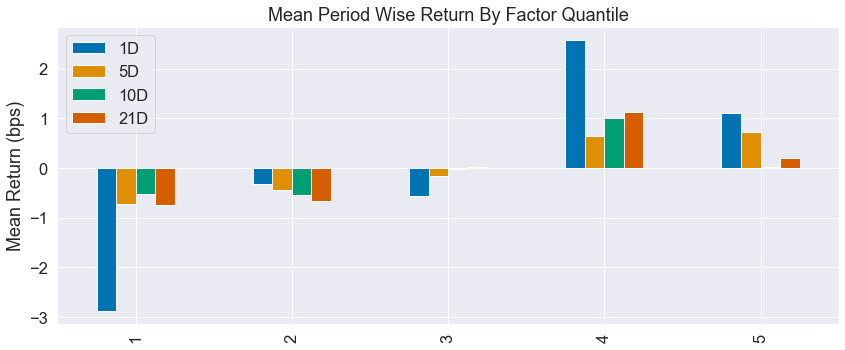

In [17]:
#分析结果摘要
create_summary_tear_sheet(lr_factor_data); #默认计算是基于多空组合的
#Quantiles Statistics
    #分位组统计，随着分组的增长，收入的均值也在上升
#Return Analysis
    #用市场超额收益率和因子多空组合作为自变量和因变量做回归（即用CAPM来检验因子的有效性）
    #Compute the alpha (excess returns), alpha t-stat (alpha significance),
    #and beta (market exposure) of a factor. A regression is run with
    #the period wise factor universe mean return as the independent variable
    #and mean period wise return from a portfolio weighted by factor values
    #as the dependent variable.
#Information Analysis
    #分析因子与收益之间的相关性
#Turnover Analysis
    #分析换手率的变化 #可见时间间隔越长，每个组中需要换手的股票占比越大
#Mean Factor Rank Autocorrelation
    #反映因子所在分位组的时序稳定性

## Ridge Regression

In [18]:
best_ridge_alpha = get_best_alpha(ridge_scores)
ridge_predictions = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha].drop('alpha', axis=1)

In [19]:
ridge_factor = get_factor(ridge_predictions.predicted.swaplevel())
ridge_factor.head()

date                       symbol
2014-12-09 00:00:00+00:00  AAL       0.001953
                           AAPL     -0.001374
                           ABBV      0.001091
                           AGN       0.001934
                           AIG      -0.000471
dtype: float64

In [20]:
ridge_factor_data = get_clean_factor_and_forward_returns(factor=ridge_factor,
                                                         prices=trade_prices,
                                                         quantiles=5,
                                                         periods=(1, 5, 10, 21))
ridge_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 74054 entries, (Timestamp('2014-12-09 00:00:00+0000', tz='UTC', freq='C'), 'AAL') to (Timestamp('2017-11-29 00:00:00+0000', tz='UTC', freq='C'), 'XOM')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               74054 non-null  float64
 1   5D               74054 non-null  float64
 2   10D              74054 non-null  float64
 3   21D              74054 non-null  float64
 4   factor           74054 non-null  float64
 5   factor_quantile  74054 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB


In [ ]:
create_summary_tear_sheet(ridge_factor_data);

## Lasso Regression

In [ ]:
best_lasso_alpha = get_best_alpha(lasso_scores)
lasso_predictions = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha].drop('alpha', axis=1)

In [ ]:
lasso_factor = get_factor(lasso_predictions.predicted.swaplevel())
lasso_factor.head()

In [ ]:
lasso_factor_data = get_clean_factor_and_forward_returns(factor=lasso_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 5, 10, 21))
lasso_factor_data.info()

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.044839,0.009398,-0.003459,0.003828,14982,20.231183
2,-0.014281,0.011321,-0.001359,0.003232,14877,20.089394
3,-0.012327,0.013100,-0.000258,0.003285,14336,19.358846
4,-0.010948,0.015352,0.000791,0.003434,14877,20.089394
5,-0.009000,0.038298,0.002835,0.004327,14982,20.231183


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.034,0.022,0.012,0.009
beta,-0.009,-0.078,-0.058,0.014
Mean Period Wise Return Top Quantile (bps),1.967,0.778,0.044,0.238
Mean Period Wise Return Bottom Quantile (bps),-2.507,-0.772,-0.764,-0.906
Mean Period Wise Spread (bps),4.473,1.579,0.827,1.134


Information Analysis


,1D,5D,10D,21D
IC Mean,0.020,0.014,0.013,0.014
IC Std.,0.181,0.168,0.168,0.155
Risk-Adjusted IC,0.111,0.082,0.075,0.093
t-stat(IC),3.037,2.239,2.058,2.551
p-value(IC),0.002,0.025,0.040,0.011
IC Skew,0.002,-0.011,-0.035,-0.022
IC Kurtosis,-0.152,-0.192,-0.161,-0.307


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.296,0.517,0.619,0.728
Quantile 2 Mean Turnover,0.513,0.705,0.752,0.789
Quantile 3 Mean Turnover,0.566,0.737,0.778,0.806
Quantile 4 Mean Turnover,0.504,0.698,0.752,0.783
Quantile 5 Mean Turnover,0.297,0.527,0.636,0.739


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.822,0.553,0.397,0.243


<Figure size 432x288 with 0 Axes>

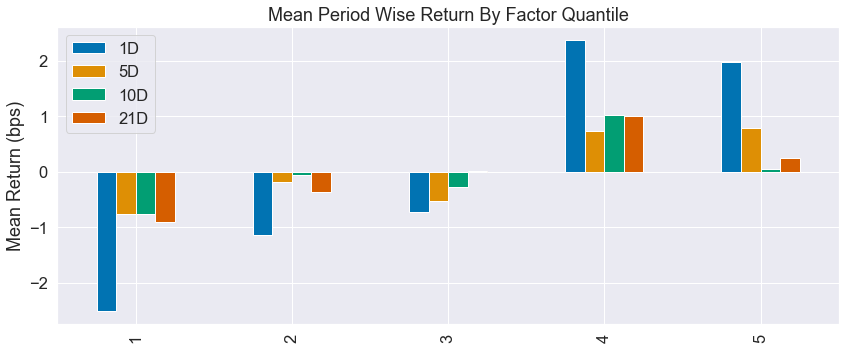

In [38]:
create_summary_tear_sheet(lasso_factor_data);